In [ ]:
import os
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn import linear_model

path = "./data/"
filename_read = os.path.join(path,"auto-mpg.csv")

mainDF = pd.read_csv(filename_read, na_values=['NA','?'], encoding="ISO-8859-1");

print('Number of instances = %d' % (mainDF.shape[0]))
print('Number of attributes = %d' % (mainDF.shape[1]))
print('Number of missing values:')
for col in mainDF.columns:
    print('\t%s: %d' % (col,mainDF[col].isna().sum()))

# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)

missing_median(mainDF, 'horsepower')
print('~Fill in missing data with median~')
print('Number of missing values:')
for col in mainDF.columns:
    print('\t%s: %d' % (col,mainDF[col].isna().sum()))


Number of instances = 398
Number of attributes = 9
Number of missing values:
	mpg: 0
	cylinders: 0
	displacement: 0
	horsepower: 6
	weight: 0
	acceleration: 0
	year: 0
	origin: 0
	name: 0
~Fill in missing data with median~
Number of missing values:
	mpg: 0
	cylinders: 0
	displacement: 0
	horsepower: 0
	weight: 0
	acceleration: 0
	year: 0
	origin: 0
	name: 0


In [ ]:
mainDF.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130.0,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449,10.5,70,1,ford torino


In [ ]:
drop_cols_simple = ['displacement','year','origin','name']
simpleDF = mainDF
simpleDF.drop(drop_cols_simple,inplace=True,axis=1)
numTrain = round(simpleDF.shape[0] * 0.8)   # number of training instances
numTest = simpleDF.shape[0] - numTrain



simpleDF.head(5)

,mpg,cylinders,horsepower,weight,acceleration
0,18.0,8,130.0,3504,12.0
1,15.0,8,165.0,3693,11.5
2,18.0,8,150.0,3436,11.0
3,16.0,8,150.0,3433,12.0
4,17.0,8,140.0,3449,10.5


# Correlation Table

In [ ]:
simpleDF.corr()

,mpg,cylinders,horsepower,weight,acceleration
mpg,1.000000,-0.775396,-0.773453,-0.831741,0.420289
cylinders,-0.775396,1.000000,0.841284,0.896017,-0.505419
horsepower,-0.773453,0.841284,1.000000,0.862442,-0.686590
weight,-0.831741,0.896017,0.862442,1.000000,-0.417457
acceleration,0.420289,-0.505419,-0.686590,-0.417457,1.000000


# Simple Linear Regression
Weight (independent) vs MPG (dependent)

Weight is normalized (min-max) before any calculations are done.

In [ ]:
mpg_df = simpleDF.drop(['cylinders','horsepower','acceleration'], axis=1);
mpg_df.head()

,mpg,weight
0,18.0,3504
1,15.0,3693
2,18.0,3436
3,16.0,3433
4,17.0,3449


In [ ]:
import collections
#Function to normalize columns
def normalize_numeric_minmax(df, name):
        df[name] = ((df[name] - df[name].min()) / (df[name].max() - df[name].min())).astype(np.float32)
# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, collections.Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)
# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

#normalizing inputs (dependent variables)    
normalize_numeric_minmax(mpg_df,"weight")
mpg_df.head(100)

,mpg,weight
0,18.0,0.536150
1,15.0,0.589736
2,18.0,0.516870
3,16.0,0.516019
4,17.0,0.520556
...,...,...
95,12.0,0.946413
96,13.0,0.626028
97,18.0,0.427559
98,16.0,0.472073


In [ ]:
# to xy to convert pandas to tensor flow
x1,y1=to_xy(mpg_df,"mpg")

In [ ]:
from sklearn.model_selection import train_test_split
x1_train, x1_test, y1_train, y1_test = train_test_split(x1,y1, test_size=0.3, random_state=42)

Text(0.5, 1.0, 'Weight vs MPG for Train Data')

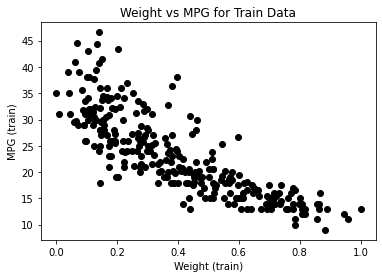

In [ ]:
# plotting out the training data
plt.scatter(x1_train, y1_train, color='black')
plt.xlabel('Weight (train)')
plt.ylabel('MPG (train)')
plt.title('Weight vs MPG for Train Data') 

In [ ]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

# Create linear regression object
mpg_regr = linear_model.LinearRegression()
# Fit regression model to the training set
mpg_regr.fit(x1_train, y1_train)
#print(x1_train)

LinearRegression()

In [ ]:
y1_pred = mpg_regr.predict(x1_test)
print('Predicted Function: y = %.2fX + %.2f' % (mpg_regr.coef_, mpg_regr.intercept_))
for i in range(10):
    print("True MPG: ",y1_test[i],"Prediction : ", y1_pred[i])

Predicted Function: y = -27.67X + 34.28
True MPG:  33.0 Prediction :  32.85717
True MPG:  28.0 Prediction :  26.346588
True MPG:  19.0 Prediction :  26.275991
True MPG:  13.0 Prediction :  16.031628
True MPG:  14.0 Prediction :  13.701937
True MPG:  27.0 Prediction :  30.464727
True MPG:  24.0 Prediction :  24.464008
True MPG:  13.0 Prediction :  9.795586
True MPG:  17.0 Prediction :  15.090338
True MPG:  21.0 Prediction :  24.385569


Root mean squared error = 3.9777
R-squared = 0.7243


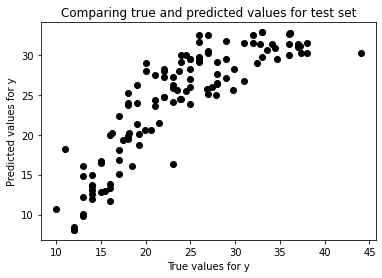

In [ ]:
# Comparing true versus predicted values
plt.scatter(y1_test, y1_pred, color='black')
plt.title('Comparing true and predicted values for test set')
plt.xlabel('True values for y')
plt.ylabel('Predicted values for y')

# Model evaluation
print("Root mean squared error = %.4f" % np.sqrt(mean_squared_error(y1_test, y1_pred)))
print('R-squared = %.4f' % r2_score(y1_test, y1_pred))

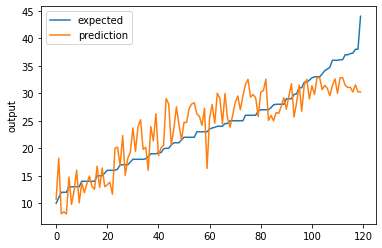

In [ ]:
chart_regression(y1_pred,y1_test)

Slope =  [-27.66606]
Intercept =  34.284794


Text(0, 0.5, 'MPG(test)')

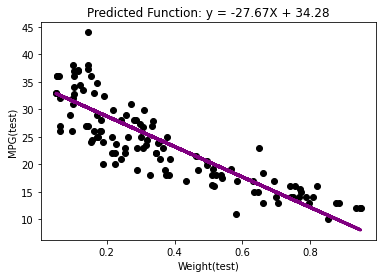

In [ ]:
print('Slope = ', mpg_regr.coef_)
print('Intercept = ', mpg_regr.intercept_)

plt.scatter(x1_test, y1_test,color='black')
plt.plot(x1_test, y1_pred,color='purple',linewidth=3)
titlestr = 'Predicted Function: y = %.2fX + %.2f' % (mpg_regr.coef_, mpg_regr.intercept_)
plt.title(titlestr)
plt.xlabel('Weight(test)')
plt.ylabel('MPG(test)')

### Prediction of Value Outside Range
Greater than 2, since the data was already normalized using min-max.

In [ ]:
outside_value = np.array([[3]])
pred_outside = mpg_regr.predict(outside_value)
print("Prediction : ", pred_outside)

Prediction :  [-48.71338463]


Prediction Function with Test and Training data swapped

In [ ]:
mpg_regr_testdata = linear_model.LinearRegression()
mpg_regr_testdata.fit(x1_test, y1_test)
y1_pred_testdata = mpg_regr_testdata.predict(x1_train)
print('Predicted Function: y = %.2fX + %.2f' % (mpg_regr_testdata.coef_, mpg_regr_testdata.intercept_))
for i in range(10):
    print("True MPG: ",y1_train[i],"Prediction : ", y1_pred_testdata[i])

Predicted Function: y = -25.96X + 33.25
True MPG:  15.0 Prediction :  12.441818
True MPG:  21.0 Prediction :  27.449055
True MPG:  21.0 Prediction :  26.080076
True MPG:  20.5 Prediction :  21.899542
True MPG:  21.0 Prediction :  25.631111
True MPG:  25.4 Prediction :  23.776367
True MPG:  34.1 Prediction :  30.510855
True MPG:  27.0 Prediction :  23.408361
True MPG:  36.0 Prediction :  29.48044
True MPG:  31.6 Prediction :  25.726791


###Cross Validation

In [ ]:
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold

rkfx1,rkfy1=to_xy(mpg_df,"mpg")  
rkf = RepeatedKFold(n_splits=10, n_repeats=4, random_state=None)  
rkfcount = 1
for train_index, test_index in rkf.split(rkfx1): 
  #print("Train:", train_index, "Validation:",test_index) 
  rkfx1_train, rkfx1_test = rkfx1[train_index], rkfx1[test_index]  
  rkfy1_train, rkfy1_test = rkfy1[train_index], rkfy1[test_index]
  rkf1_regr = linear_model.LinearRegression()
  rkf1_regr.fit(rkfx1_train, rkfy1_train)
  rkf1_pred = rkf1_regr.predict(rkfx1_test)
  print(rkfcount)
  print('Predicted Function: y = %.2fX + %.2f' % (rkf1_regr.coef_, rkf1_regr.intercept_))
  #for i in range(5):
    #print("True MPG: ",rkfy1_test[i],"Prediction : ", rkf1_pred[i])
  print("Root mean squared error = %.4f" % np.sqrt(mean_squared_error(rkfy1_test, rkf1_pred)))
  print('R-squared = %.4f' % r2_score(rkfy1_test, rkf1_pred))
  rkfcount = rkfcount + 1

1
Predicted Function: y = -26.86X + 33.84
Root mean squared error = 4.1265
R-squared = 0.7276
2
Predicted Function: y = -26.55X + 33.60
Root mean squared error = 5.5287
R-squared = 0.6083
3
Predicted Function: y = -27.03X + 33.99
Root mean squared error = 3.9641
R-squared = 0.7281
4
Predicted Function: y = -27.64X + 34.24
Root mean squared error = 4.2902
R-squared = 0.6048
5
Predicted Function: y = -27.12X + 33.90
Root mean squared error = 4.5426
R-squared = 0.5687
6
Predicted Function: y = -27.07X + 33.97
Root mean squared error = 3.7359
R-squared = 0.7747
7
Predicted Function: y = -27.14X + 34.00
Root mean squared error = 4.9072
R-squared = 0.5751
8
Predicted Function: y = -27.27X + 33.89
Root mean squared error = 4.2933
R-squared = 0.7446
9
Predicted Function: y = -26.93X + 33.95
Root mean squared error = 4.3139
R-squared = 0.6678
10
Predicted Function: y = -27.12X + 33.96
Root mean squared error = 3.4620
R-squared = 0.7265
11
Predicted Function: y = -26.90X + 33.88
Root mean square

# Multiple Linear Regression
MPG (Dependent) vs Weight and Horsepower (Independent)

In [ ]:
# dep: MPG   |   indep: weight, horsepower
mpg_mlrDF = simpleDF.drop(['cylinders','acceleration'], axis=1)
mpg_mlrDF.head()

,mpg,horsepower,weight
0,18.0,130.0,3504
1,15.0,165.0,3693
2,18.0,150.0,3436
3,16.0,150.0,3433
4,17.0,140.0,3449


In [ ]:
normalize_numeric_minmax(mpg_mlrDF,'weight')
normalize_numeric_minmax(mpg_mlrDF,'horsepower')
mpg_mlrDF.head()

,mpg,horsepower,weight
0,18.0,0.456522,0.536150
1,15.0,0.646739,0.589736
2,18.0,0.565217,0.516870
3,16.0,0.565217,0.516019
4,17.0,0.510870,0.520556


In [ ]:
x2,y2=to_xy(mpg_mlrDF,'mpg')
# 30% test, 70% train
x2_train, x2_test, y2_train, y2_test = train_test_split(x2,y2, test_size=0.3, random_state=42)

horseTest = x2_test[:, 0]
horseTrain = x2_train[:, 0]
weightTest = x2_test[:, 1]
weightTrain = x2_train[:, 1]

# create linear regression object
mpgMLR_regr = linear_model.LinearRegression()
horse_regr = linear_model.LinearRegression()
weight_regr = linear_model.LinearRegression()
mpgMLR_regr_testdata = linear_model.LinearRegression()

# fit regression model to training set
mpgMLR_regr.fit(x2_train,y2_train)
horse_regr.fit(horseTrain.reshape(-1,1),y2_train)
weight_regr.fit(weightTrain.reshape(-1,1),y2_train)
mpgMLR_regr_testdata.fit(x2_test, y2_test)

# prediction set
y2_pred = mpgMLR_regr.predict(x2_test)
horsey2_pred = horse_regr.predict(horseTest.reshape(-1,1))
weighty2_pred = weight_regr.predict(weightTest.reshape(-1,1))
y2_pred_testdata = mpgMLR_regr_testdata.predict(x2_train)

In [ ]:
print('Intercept: \n', mpgMLR_regr.intercept_)
print('Coefficients: \n', mpgMLR_regr.coef_)

Intercept: 
 34.61667
Coefficients: 
 [ -8.991634 -21.349674]


Text(0.5, 1.0, 'Predicted Function: y = -27.67x + 34.28')

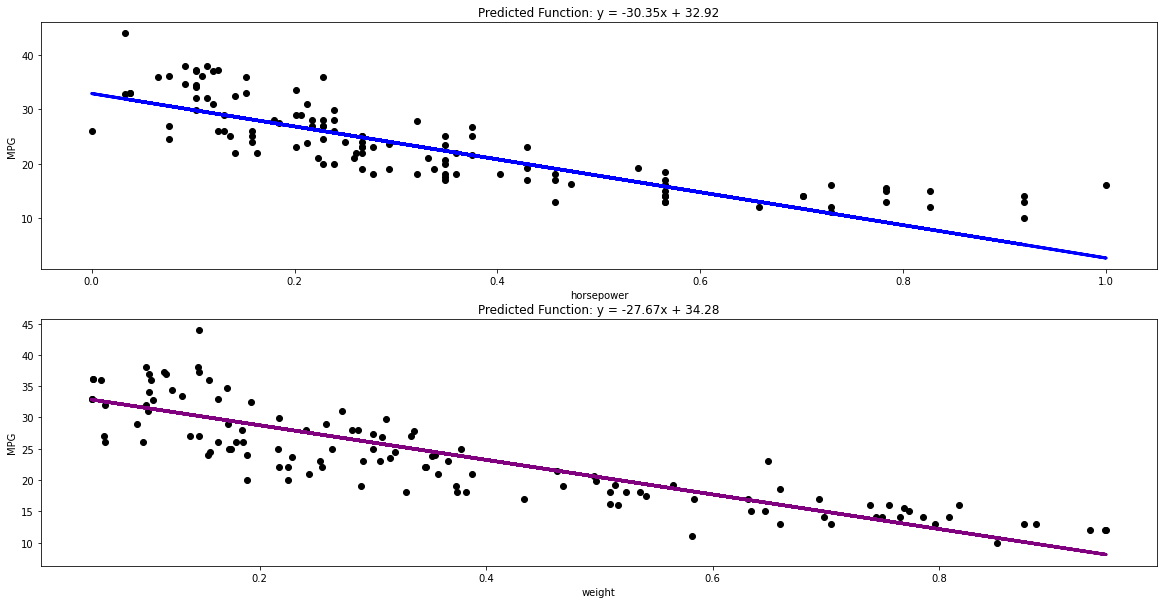

In [ ]:
fig, ax = plt.subplots(2, figsize=(20,10))
ax[0].scatter(horseTest,y2_test, color='black')
ax[0].set_xlabel('horsepower')
ax[0].set_ylabel('MPG')
ax[0].plot(horseTest, horsey2_pred , color='blue', linewidth=3)
titlestr = 'Predicted Function: y = %.2fx + %.2f' % (horse_regr.coef_[0],horse_regr.intercept_)
ax[0].set_title(titlestr)

ax[1].scatter(weightTest,y2_test, color='black')
ax[1].set_xlabel('weight')
ax[1].set_ylabel('MPG')
ax[1].plot(weightTest, weighty2_pred, color='purple', linewidth=3)
titlestr = 'Predicted Function: y = %.2fx + %.2f' % (weight_regr.coef_[0],weight_regr.intercept_)
ax[1].set_title(titlestr)


In [ ]:
print("\nPrediction Table for MPG based off Horsepower")
print('Predicted Function: y = %.2fx + %.2f' % (horse_regr.coef_[0],horse_regr.intercept_))
for i in range(4):
    print("True MPG : ",y2_test[i],"| Prediction : ", horsey2_pred[i],"| HP : ", horseTest[i])
print("\nPrediction Table for MPG based off Weight")
print('Predicted Function: y = %.2fx + %.2f' % (weight_regr.coef_[0],weight_regr.intercept_))
for i in range(4):
    print("True MPG : ",y2_test[i],"| Prediction : ", weighty2_pred[i],"| Weight : ", weightTest[i])
print("\nPrediction Table for MPG based off Horsepower and Weight")
print('Predicted Function: y = %.2fx1 + %.2fx2 + %.2f' % (mpgMLR_regr.coef_[1],mpgMLR_regr.coef_[0],mpgMLR_regr.intercept_))
for i in range(4):
    print("True MPG : ",y2_test[i],"| Prediction : ", y2_pred[i],"| HP : ", horseTest[i], "and Weight : ", weightTest[i])


Prediction Table for MPG based off Horsepower
Predicted Function: y = -30.35x + 32.92
True MPG :  33.0 | Prediction :  31.763006 | HP :  0.038043477
True MPG :  28.0 | Prediction :  27.475115 | HP :  0.17934783
True MPG :  19.0 | Prediction :  24.011818 | HP :  0.29347825
True MPG :  13.0 | Prediction :  15.765873 | HP :  0.5652174

Prediction Table for MPG based off Weight
Predicted Function: y = -27.67x + 34.28
True MPG :  33.0 | Prediction :  32.85717 | Weight :  0.051601928
True MPG :  28.0 | Prediction :  26.346588 | Weight :  0.2869294
True MPG :  19.0 | Prediction :  26.275991 | Weight :  0.28948113
True MPG :  13.0 | Prediction :  16.031628 | Weight :  0.6597675

Prediction Table for MPG based off Horsepower and Weight
Predicted Function: y = -21.35x1 + -8.99x2 + 34.62
True MPG :  33.0 | Prediction :  33.172913 | HP :  0.038043477 and Weight :  0.051601928
True MPG :  28.0 | Prediction :  26.87819 | HP :  0.17934783 and Weight :  0.2869294
True MPG :  19.0 | Prediction :  25.7

Root mean squared error = 3.9490
R-squared = 0.7283


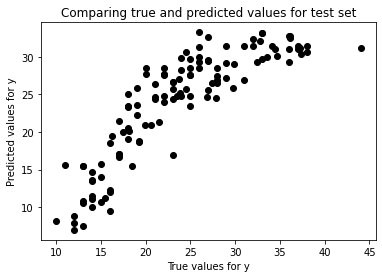

In [ ]:
# Comparing true versus predicted values
plt.scatter(y2_test, y2_pred, color='black')
plt.title('Comparing true and predicted values for test set')
plt.xlabel('True values for y')
plt.ylabel('Predicted values for y')

# Model evaluation
print("Root mean squared error = %.4f" % np.sqrt(mean_squared_error(y2_test, y2_pred)))
print('R-squared = %.4f' % r2_score(y2_test, y2_pred))

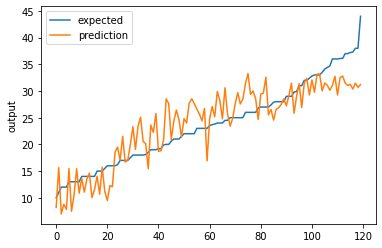

In [ ]:
chart_regression(y2_pred,y2_test)

### Prediction of Value Outside Range
Greater than 2, since the data was already normalized using min-max. Deciding attribute is horsepower.

In [ ]:
outside_value = np.array([[3]])
pred_outside = horse_regr.predict(outside_value)
print("Prediction : ", pred_outside)

Prediction :  [-58.11779976]


Prediction Function with Test and Training data swapped

In [ ]:
print('Slope = ', mpgMLR_regr_testdata.coef_)
print('Intercept = ', mpgMLR_regr_testdata.intercept_)

print("\nPrediction Table for Chance of Admit based off GRE Score and CGPA")
print('Predicted Function: y = %.2fx1 + %.2fx2 + %.2f' % (mpgMLR_regr_testdata.coef_[1],mpgMLR_regr_testdata.coef_[0],mpgMLR_regr_testdata.intercept_))
for i in range(10):
    print("True Chance of Admit : ",y2_train[i],"| Prediction : ", y2_pred_testdata[i],"| GRE Score : ", horseTrain[i], "and CGPA : ", weightTrain[i])

Slope =  [ -7.545222 -19.586317]
Intercept =  33.371933

Prediction Table for Chance of Admit based off GRE Score and CGPA
Predicted Function: y = -19.59x1 + -7.55x2 + 33.37
True Chance of Admit :  15.0 | Prediction :  13.613235 | GRE Score :  0.5380435 and CGPA :  0.801531
True Chance of Admit :  21.0 | Prediction :  27.929798 | GRE Score :  0.14130434 and CGPA :  0.22341934
True Chance of Admit :  21.0 | Prediction :  26.363808 | GRE Score :  0.21195652 and CGPA :  0.27615538
True Chance of Admit :  20.5 | Prediction :  22.799496 | GRE Score :  0.26630434 and CGPA :  0.43719876
True Chance of Admit :  21.0 | Prediction :  25.820026 | GRE Score :  0.23913044 and CGPA :  0.29345053
True Chance of Admit :  25.4 | Prediction :  23.354435 | GRE Score :  0.38043478 and CGPA :  0.36489934
True Chance of Admit :  34.1 | Prediction :  30.403976 | GRE Score :  0.11956522 and CGPA :  0.10547207
True Chance of Admit :  27.0 | Prediction :  24.142944 | GRE Score :  0.23913044 and CGPA :  0.379075

# Part B: Classification

In [ ]:
filename_read2 = os.path.join(path,"Admission_Predict_Ver1.1_small_data_set_for_Linear_Regression.csv")
classDF = pd.read_csv(filename_read2, na_values=['NA','?'], encoding="ISO-8859-1")
classDF.drop(['Serial No.'],inplace=True,axis=1)
print('Number of instances = %d' % (classDF.shape[0]))
print('Number of attributes = %d' % (classDF.shape[1]))
print('Number of missing values:')
for col in classDF.columns:
    print('\t%s: %d' % (col,classDF[col].isna().sum()))
classDF.head()

Number of instances = 500
Number of attributes = 8
Number of missing values:
	GRE Score: 0
	TOEFL Score: 0
	University Rating: 0
	SOP: 0
	LOR : 0
	CGPA: 0
	Research: 0
	Chance of Admit : 0


,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,337,118,4,4.5,4.5,9.65,1,0.92
1,324,107,4,4.0,4.5,8.87,1,0.76
2,316,104,3,3.0,3.5,8.00,1,0.72
3,322,110,3,3.5,2.5,8.67,1,0.80
4,314,103,2,2.0,3.0,8.21,0,0.65


In [ ]:
# discretizing Chance of Admit
#bins = [0, 33.33, 66.67, 100]
classDF['Chance of Admit '] = pd.to_numeric(classDF['Chance of Admit '], errors='coerce')
#classDF['Chance of Admit'] = pd.cut(classDF['Chance of Admit ', bin])
classDF.loc[classDF['Chance of Admit '].between(0,0.5, 'left'),'Admission Chance'] = 'Less than 50%'
classDF.loc[classDF['Chance of Admit '].between(0.5,0.75,'both'),'Admission Chance'] = 'Between 50-75%'
classDF.loc[classDF['Chance of Admit '].between(0.75,1,'right'), 'Admission Chance'] = 'More than 75%'
classDF.drop(['Chance of Admit '],inplace=True,axis=1)
classDF.head(20)

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Admission Chance
0,337,118,4,4.5,4.5,9.65,1,More than 75%
1,324,107,4,4.0,4.5,8.87,1,More than 75%
2,316,104,3,3.0,3.5,8.00,1,Between 50-75%
3,322,110,3,3.5,2.5,8.67,1,More than 75%
4,314,103,2,2.0,3.0,8.21,0,Between 50-75%
5,330,115,5,4.5,3.0,9.34,1,More than 75%
6,321,109,3,3.0,4.0,8.20,1,Between 50-75%
7,308,101,2,3.0,4.0,7.90,0,Between 50-75%
8,302,102,1,2.0,1.5,8.00,0,Between 50-75%
9,323,108,3,3.5,3.0,8.60,0,Less than 50%


In [ ]:
print(classDF['Admission Chance'].value_counts().sort_values(ascending=False))

Between 50-75%    253
More than 75%     210
Less than 50%      37
Name: Admission Chance, dtype: int64


In [ ]:
from sklearn import tree
# ['GRE Score','TOEFL Score','University Rating','SOP','LOR ','CGPA','Research']
classX_train, classX_test, classY_train, classY_test = train_test_split(classDF[['GRE Score','TOEFL Score','University Rating','SOP','LOR ','CGPA','Research']],classDF['Admission Chance'],test_size=0.20, random_state=50)

clf = tree.DecisionTreeClassifier(criterion='entropy',max_depth=7)
clf = clf.fit(classX_train, classY_train)

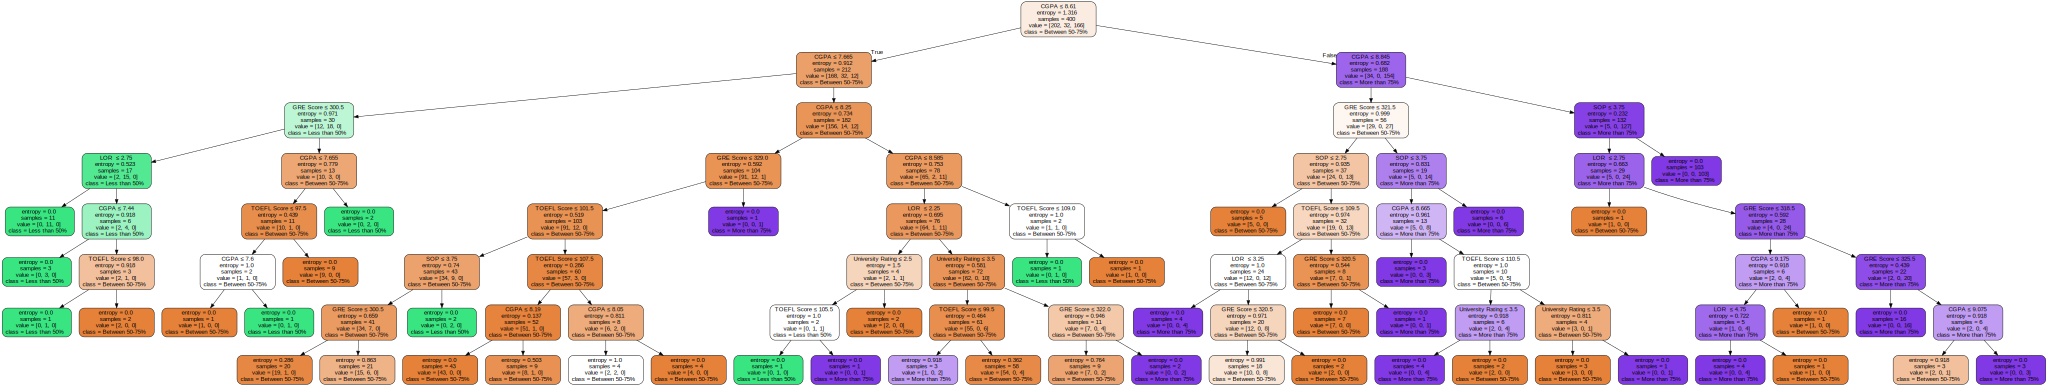

In [ ]:
import graphviz  

dot_data = tree.export_graphviz(clf, out_file =None,feature_names =classX_train.columns,class_names=['Between 50-75%','Less than 50%','More than 75%'], filled=True, rounded=True, special_characters=True)  

graph = graphviz.Source(dot_data)  
graph

[[43  1  7]
 [ 3  2  0]
 [ 5  0 39]]
Accuracy on test data is 0.84
F1 score on test data is 0.84
Precision Score on test data is 0.84
Recall score on test data is 0.84
                precision    recall  f1-score   support

Between 50-75%       0.84      0.84      0.84        51
 Less than 50%       0.67      0.40      0.50         5
 More than 75%       0.85      0.89      0.87        44

      accuracy                           0.84       100
     macro avg       0.79      0.71      0.74       100
  weighted avg       0.84      0.84      0.84       100



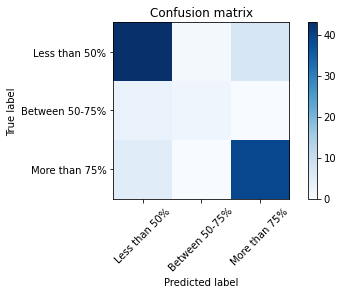

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score,recall_score,classification_report

# Plot a confusion matrix.
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

predClassY = clf.predict(classX_test)

confusion = confusion_matrix(classY_test, predClassY)
print(confusion)

plot_confusion_matrix(confusion, ['Less than 50%','Between 50-75%','More than 75%'], title='Confusion matrix', cmap=plt.cm.Blues)

print('Accuracy on test data is %.2f' % (accuracy_score(classY_test, predClassY)))
print('F1 score on test data is %.2f' % (f1_score(classY_test, predClassY, average='weighted')))
print('Precision Score on test data is %.2f' % (precision_score(classY_test, predClassY, average='weighted')))
print('Recall score on test data is %.2f' % (recall_score(classY_test, predClassY, average='weighted')))
print( classification_report(classY_test,predClassY))

# Part B: Admission Regression

In [ ]:
path = "./data/"
filename_read3 = os.path.join(path,"Admission_Predict_Ver1.1_small_data_set_for_Linear_Regression.csv")
mainDF = pd.read_csv(filename_read3, na_values=['NA','?'], encoding="ISO-8859-1");

print('Number of instances = %d' % (mainDF.shape[0]))
print('Number of attributes = %d' % (mainDF.shape[1]))
print('Number of missing values:')
for col in mainDF.columns:
    print('\t%s: %d' % (col,mainDF[col].isna().sum()))

mainDF.head()

Number of instances = 500
Number of attributes = 9
Number of missing values:
	Serial No.: 0
	GRE Score: 0
	TOEFL Score: 0
	University Rating: 0
	SOP: 0
	LOR : 0
	CGPA: 0
	Research: 0
	Chance of Admit : 0


,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,1,337,118,4,4.5,4.5,9.65,1,0.92
1,2,324,107,4,4.0,4.5,8.87,1,0.76
2,3,316,104,3,3.0,3.5,8.00,1,0.72
3,4,322,110,3,3.5,2.5,8.67,1,0.80
4,5,314,103,2,2.0,3.0,8.21,0,0.65


In [ ]:
drop_cols_simple = ['LOR ']
simpleDF = mainDF
simpleDF.drop(drop_cols_simple,inplace=True,axis=1)
numTrain = 20   # number of training instances
numTest = simpleDF.shape[0] - numTrain

coa_train = simpleDF[:-numTest]
coa_test = simpleDF[-numTest:]
coa_train = simpleDF[:-numTest]
coa_test = simpleDF[-numTest:]

print('Number of instances = %d' % (coa_train.shape[0]))
print('Number of attributes = %d' % (coa_test.shape[0]))
simpleDF.head(20)

Number of instances = 20
Number of attributes = 480


,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,CGPA,Research,Chance of Admit
0,1,337,118,4,4.5,9.65,1,0.92
1,2,324,107,4,4.0,8.87,1,0.76
2,3,316,104,3,3.0,8.00,1,0.72
3,4,322,110,3,3.5,8.67,1,0.80
4,5,314,103,2,2.0,8.21,0,0.65
5,6,330,115,5,4.5,9.34,1,0.90
6,7,321,109,3,3.0,8.20,1,0.75
7,8,308,101,2,3.0,7.90,0,0.68
8,9,302,102,1,2.0,8.00,0,0.50
9,10,323,108,3,3.5,8.60,0,0.45


# Correlation Table for Admission Data

In [ ]:
simpleDF.corr()

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,CGPA,Research,Chance of Admit
Serial No.,1.000000,-0.103839,-0.141696,-0.067641,-0.137352,-0.074289,-0.005332,0.008505
GRE Score,-0.103839,1.000000,0.827200,0.635376,0.613498,0.825878,0.563398,0.810351
TOEFL Score,-0.141696,0.827200,1.000000,0.649799,0.644410,0.810574,0.467012,0.792228
University Rating,-0.067641,0.635376,0.649799,1.000000,0.728024,0.705254,0.427047,0.690132
SOP,-0.137352,0.613498,0.644410,0.728024,1.000000,0.712154,0.408116,0.684137
CGPA,-0.074289,0.825878,0.810574,0.705254,0.712154,1.000000,0.501311,0.882413
Research,-0.005332,0.563398,0.467012,0.427047,0.408116,0.501311,1.000000,0.545871
Chance of Admit,0.008505,0.810351,0.792228,0.690132,0.684137,0.882413,0.545871,1.000000


# Simple Linear Regression
GRE Score (Independent) vs Chance of Admit (Dependent)

GRE Score is normalized before any calculations are done.

Text(0.5, 1.0, 'GRE Score vs Admission Chance for Train Data')

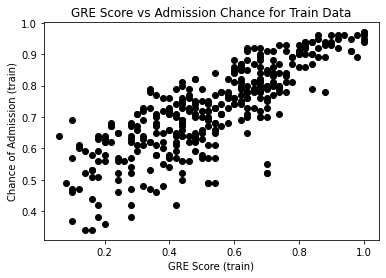

In [ ]:
simpleDF = simpleDF.filter(['GRE Score','Chance of Admit '])
# normalizing input (independent variable)
normalize_numeric_minmax(simpleDF,'GRE Score')

x3,y3=to_xy(simpleDF,'Chance of Admit ')

x3_train, x3_test, y3_train, y3_test = train_test_split(x3,y3,test_size=0.3, random_state=42)

plt.scatter(x3_train,y3_train, color='black')
plt.xlabel('GRE Score (train)')
plt.ylabel('Chance of Admission (train)')
plt.title('GRE Score vs Admission Chance for Train Data')

In [ ]:
chance_regr = linear_model.LinearRegression()
chance_regr.fit(x3_train, y3_train)

y3_pred = chance_regr.predict(x3_test)
print('Predicted Function: y = %.2fX + %.2f' % (chance_regr.coef_, chance_regr.intercept_))
for i in range(10):
  print("True Admission Chance: ", y3_test[i], "Prediction: ",y3_pred[i])

Predicted Function: y = 0.52X + 0.45
True Admission Chance:  0.93 Prediction:  0.9048516
True Admission Chance:  0.84 Prediction:  0.6966988
True Admission Chance:  0.39 Prediction:  0.7071064
True Admission Chance:  0.77 Prediction:  0.6758835
True Admission Chance:  0.74 Prediction:  0.8215905
True Admission Chance:  0.89 Prediction:  0.85281336
True Admission Chance:  0.47 Prediction:  0.44691536
True Admission Chance:  0.57 Prediction:  0.5613994
True Admission Chance:  0.68 Prediction:  0.73832935
True Admission Chance:  0.82 Prediction:  0.75914466


Root mean squared error = 0.0871
R-squared = 0.6357


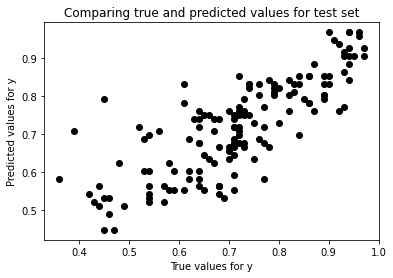

In [ ]:
# Comparing true versus predicted values
plt.scatter(y3_test, y3_pred, color='black')
plt.title('Comparing true and predicted values for test set')
plt.xlabel('True values for y')
plt.ylabel('Predicted values for y')

# Model evaluation
print("Root mean squared error = %.4f" % np.sqrt(mean_squared_error(y3_test, y3_pred)))
print('R-squared = %.4f' % r2_score(y3_test, y3_pred))

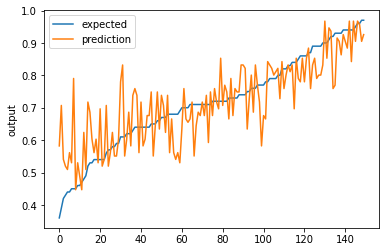

In [ ]:
chart_regression(y3_pred,y3_test)

Slope =  [0.5203821]
Intercept =  0.44691536


Text(0, 0.5, 'Chance of Admission (test)')

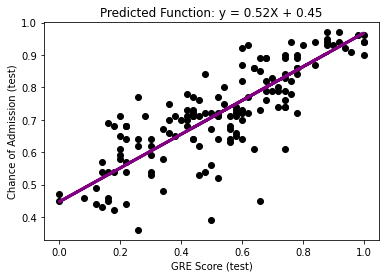

In [ ]:
print('Slope = ', chance_regr.coef_)
print('Intercept = ', chance_regr.intercept_)

plt.scatter(x3_test, y3_test,color='black')
plt.plot(x3_test, y3_pred,color='purple',linewidth=3)
titlestr = 'Predicted Function: y = %.2fX + %.2f' % (chance_regr.coef_, chance_regr.intercept_)
plt.title(titlestr)
plt.xlabel('GRE Score (test)')
plt.ylabel('Chance of Admission (test)')

### Prediction of Value Outside Range
Greater than 2, since the data was already normalized using min-max.

In [ ]:
outside_value = np.array([[3]])
pred_outside = chance_regr.predict(outside_value)
print("Prediction : ", pred_outside)

Prediction :  [2.00806168]


Prediction Function with Test and Training data swapped

In [ ]:
chance_regr_testdata = linear_model.LinearRegression()
chance_regr_testdata.fit(x3_test, y3_test)

y3_pred_testdata = chance_regr_testdata.predict(x3_test)
print('Predicted Function: y = %.2fX + %.2f' % (chance_regr_testdata.coef_, chance_regr_testdata.intercept_))
for i in range(10):
    print("True MPG: ",y3_train[i],"Prediction : ", y3_pred_testdata[i])

Predicted Function: y = 0.48X + 0.47
True MPG:  0.9 Prediction :  0.8877468
True MPG:  0.56 Prediction :  0.69614893
True MPG:  0.88 Prediction :  0.7057288
True MPG:  0.66 Prediction :  0.67698914
True MPG:  0.62 Prediction :  0.81110764
True MPG:  0.68 Prediction :  0.8398473
True MPG:  0.8 Prediction :  0.46623144
True MPG:  0.84 Prediction :  0.5716103
True MPG:  0.52 Prediction :  0.73446846
True MPG:  0.48 Prediction :  0.7536283


# Multiple Linear Regression
GRE Score and CGPA (Independent) vs Chance of Admit (Dependent)

In [ ]:
multDF = mainDF
multDF = multDF.filter(['GRE Score','Chance of Admit ','CGPA'])

normalize_numeric_minmax(multDF,'GRE Score')
normalize_numeric_minmax(multDF,'CGPA')
multDF.head()

,GRE Score,Chance of Admit,CGPA
0,0.94,0.92,0.913462
1,0.68,0.76,0.663462
2,0.52,0.72,0.384615
3,0.64,0.80,0.599359
4,0.48,0.65,0.451923


In [ ]:
x3,y3=to_xy(multDF,'Chance of Admit ')
#print(x3,y3)
# 30% test, 70% train
x3_train, x3_test, y3_train, y3_test = train_test_split(x3,y3, test_size=0.3, random_state=42)

greTest = x3_test[:, 0]
greTrain = x3_train[:, 0]
cgpaTest = x3_test[:, 1]
cgpaTrain = x3_train[:, 1]

# create linear regression object
admitMLR_regr = linear_model.LinearRegression()
gre_regr = linear_model.LinearRegression()
cgpa_regr = linear_model.LinearRegression()
admitMLR_regr_testdata = linear_model.LinearRegression()

# fit regression model to training set
admitMLR_regr.fit(x3_train,y3_train)
gre_regr.fit(greTrain.reshape(-1,1),y3_train)
cgpa_regr.fit(cgpaTrain.reshape(-1,1),y3_train)
admitMLR_regr_testdata.fit(x3_test,y3_test)

# prediction set
y3_pred = admitMLR_regr.predict(x3_test)
grey2_pred = gre_regr.predict(greTest.reshape(-1,1))
cgpay2_pred = cgpa_regr.predict(cgpaTest.reshape(-1,1))
y3_pred_testdata = admitMLR_regr_testdata.predict(x3_train)

In [ ]:
print('Intercept: \n', admitMLR_regr.intercept_)
print('Coefficients: \n', admitMLR_regr.coef_)

Intercept: 
 0.35868654
Coefficients: 
 [0.18452081 0.469171  ]


Text(0.5, 1.0, 'Predicted Function: y = 0.64x + 0.36')

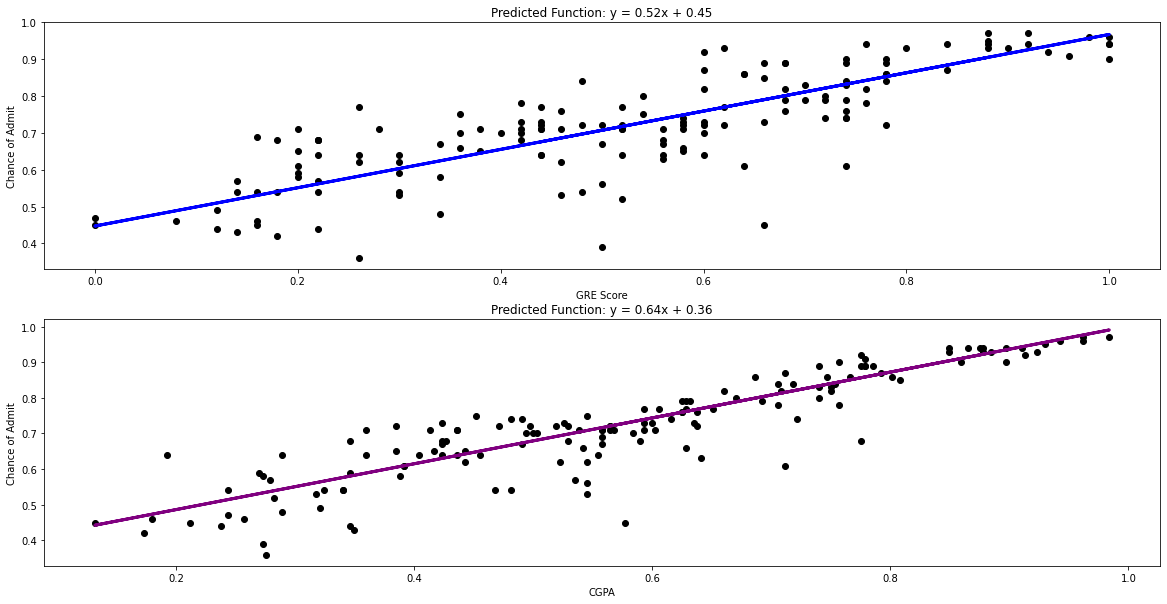

In [ ]:
fig, ax = plt.subplots(2, figsize=(20,10))
ax[0].scatter(greTest,y3_test, color='black')
ax[0].set_xlabel('GRE Score')
ax[0].set_ylabel('Chance of Admit')
ax[0].plot(greTest, grey2_pred , color='blue', linewidth=3)
titlestr = 'Predicted Function: y = %.2fx + %.2f' % (gre_regr.coef_[0],gre_regr.intercept_)
#titlestr = 'Predicted Function: y = %.2fx + %.2f' % (admitMLR_regr.coef_[0],mpgMLR_regr.intercept_)
ax[0].set_title(titlestr)

ax[1].scatter(cgpaTest,y3_test, color='black')
ax[1].set_xlabel('CGPA')
ax[1].set_ylabel('Chance of Admit')
ax[1].plot(cgpaTest, cgpay2_pred, color='purple', linewidth=3)
titlestr = 'Predicted Function: y = %.2fx + %.2f' % (cgpa_regr.coef_[0],cgpa_regr.intercept_)
#titlestr = 'Predicted Function: y = %.2fx + %.2f' % (admitMLR_regr.coef_[1],mpgMLR_regr.intercept_)
ax[1].set_title(titlestr)

In [ ]:
print("\nPrediction Table for Chance of Admit based off GRE Score")
print('Predicted Function: y = %.2fx + %.2f' % (gre_regr.coef_[0],gre_regr.intercept_))
for i in range(3):
    print("True Chance of Admit : ",y3_test[i],"| Prediction : ", grey2_pred[i],"| GRE Score : ", greTest[i])
print("\nPrediction Table for Chance of Admit based off CGPA")
print('Predicted Function: y = %.2fx + %.2f' % (cgpa_regr.coef_[0],cgpa_regr.intercept_))
for i in range(3):
    print("True Chance of Admit : ",y3_test[i],"| Prediction : ", cgpay2_pred[i],"| CGPA : ", cgpaTest[i])
print("\nPrediction Table for Chance of Admit based off GRE Score and CGPA")
print('Predicted Function: y = %.2fx1 + %.2fx2 + %.2f' % (admitMLR_regr.coef_[1],admitMLR_regr.coef_[0],admitMLR_regr.intercept_))
for i in range(3):
    print("True Chance of Admit : ",y3_test[i],"| Prediction : ", y3_pred[i],"| GRE Score : ", greTest[i], "and CGPA : ", cgpaTest[i])


Prediction Table for Chance of Admit based off GRE Score
Predicted Function: y = 0.52x + 0.45
True Chance of Admit :  0.93 | Prediction :  0.9048516 | GRE Score :  0.88
True Chance of Admit :  0.84 | Prediction :  0.6966988 | GRE Score :  0.48
True Chance of Admit :  0.39 | Prediction :  0.7071064 | GRE Score :  0.5

Prediction Table for Chance of Admit based off CGPA
Predicted Function: y = 0.64x + 0.36
True Chance of Admit :  0.93 | Prediction :  0.92276704 | CGPA :  0.8782051
True Chance of Admit :  0.84 | Prediction :  0.8196799 | CGPA :  0.71794873
True Chance of Admit :  0.39 | Prediction :  0.53309774 | CGPA :  0.2724359

Prediction Table for Chance of Admit based off GRE Score and CGPA
Predicted Function: y = 0.47x1 + 0.18x2 + 0.36
True Chance of Admit :  0.93 | Prediction :  0.9330932 | GRE Score :  0.88 and CGPA :  0.8782051
True Chance of Admit :  0.84 | Prediction :  0.7840972 | GRE Score :  0.48 and CGPA :  0.71794873
True Chance of Admit :  0.39 | Prediction :  0.578766 

Root mean squared error = 0.0646
R-squared = 0.7997


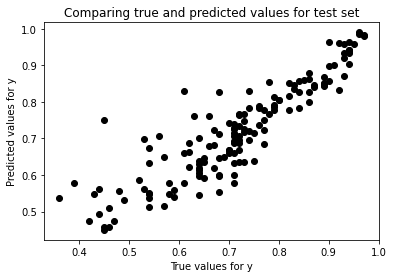

In [ ]:
# Comparing true versus predicted values
plt.scatter(y3_test, y3_pred, color='black')
plt.title('Comparing true and predicted values for test set')
plt.xlabel('True values for y')
plt.ylabel('Predicted values for y')

# Model evaluation
print("Root mean squared error = %.4f" % np.sqrt(mean_squared_error(y3_test, y3_pred)))
print('R-squared = %.4f' % r2_score(y3_test, y3_pred))

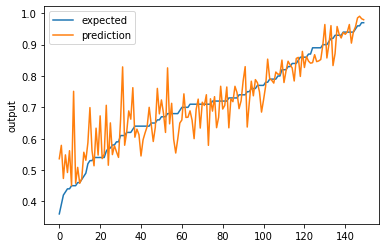

In [ ]:
chart_regression(y3_pred,y3_test)

### Prediction of Value Outside Range
Greater than 2, since the data was already normalized using min-max. Deciding attribute is CGPA.



In [ ]:
outside_value = np.array([[3]])
pred_outside = cgpa_regr.predict(outside_value)
print("Prediction : ", pred_outside)

Prediction :  [2.28764024]


Prediction Function with Test and Training data swapped

In [ ]:
print('Slope = ', admitMLR_regr_testdata.coef_)
print('Intercept = ', admitMLR_regr_testdata.intercept_)

print("\nPrediction Table for Chance of Admit based off GRE Score and CGPA")
print('Predicted Function: y = %.2fx1 + %.2fx2 + %.2f' % (admitMLR_regr_testdata.coef_[1],admitMLR_regr_testdata.coef_[0],admitMLR_regr_testdata.intercept_))
for i in range(10):
    print("True Chance of Admit : ",y3_train[i],"| Prediction : ", y3_pred_testdata[i],"| GRE Score : ", greTrain[i], "and CGPA : ", cgpaTrain[i])

Slope =  [0.10907015 0.5315402 ]
Intercept =  0.35664952

Prediction Table for Chance of Admit based off GRE Score and CGPA
Predicted Function: y = 0.53x1 + 0.11x2 + 0.36
True Chance of Admit :  0.9 | Prediction :  0.8766339 | GRE Score :  0.8 and CGPA :  0.8141026
True Chance of Admit :  0.56 | Prediction :  0.68634725 | GRE Score :  0.18 and CGPA :  0.5833333
True Chance of Admit :  0.88 | Prediction :  0.81829494 | GRE Score :  0.64 and CGPA :  0.73717946
True Chance of Admit :  0.66 | Prediction :  0.7392417 | GRE Score :  0.54 and CGPA :  0.60897434
True Chance of Admit :  0.62 | Prediction :  0.58795 | GRE Score :  0.34 and CGPA :  0.3653846
True Chance of Admit :  0.68 | Prediction :  0.5663433 | GRE Score :  0.22 and CGPA :  0.34935898
True Chance of Admit :  0.8 | Prediction :  0.7450378 | GRE Score :  0.64 and CGPA :  0.599359
True Chance of Admit :  0.84 | Prediction :  0.8005103 | GRE Score :  0.68 and CGPA :  0.69551283
True Chance of Admit :  0.52 | Prediction :  0.493563